Get ages from new VD from changing bin size for Rvar and Prot

In [53]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random

In [54]:
mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand

# For Prot

In [56]:
df_Prot_bin=pd.read_pickle('ProtVP_MS_150_w015_bin.pkl')
Vd_bins=pd.read_table('VD_bin_prot',delimiter=',')
df_rvar=pd.read_pickle('Rvars.pkl')

df_Prot_bin=pd.merge(df_Prot_bin,Vd_bins,left_on='KID',right_on='KID',how='inner')
df_Prot_bin=pd.merge(df_Prot_bin,df_rvar,left_on='KID',right_on='KID',how='inner')

Text(0, 0.5, 'Rvar [ppm]')

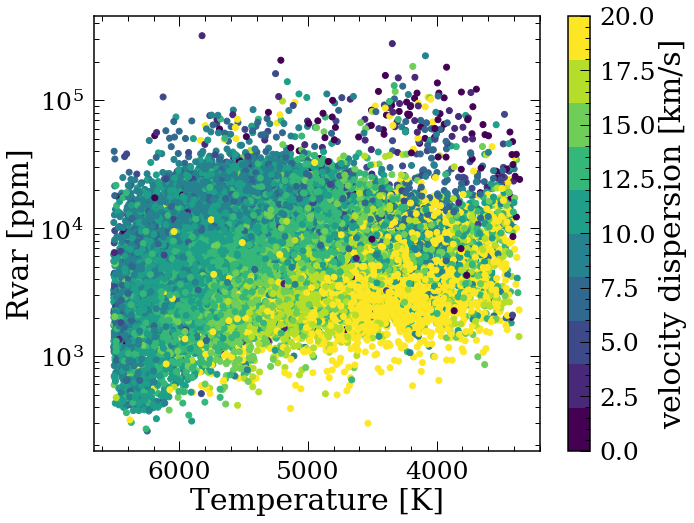

In [57]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_Prot_bin['teff_calc'],df_Prot_bin['Rvar'],c=df_Prot_bin[' vd'],cmap=cm,vmin=0,vmax=20)
plt.gca().invert_xaxis()
plt.yscale('log')
cb=plt.colorbar()
cb.set_label('velocity dispersion [km/s]')
plt.xlabel('Temperature [K]')
plt.ylabel('Rvar [ppm]')

In [58]:
p_mp, p_mr, p_a = get_avr_coefficients()
df_Prot_bin['age']=v_to_age(df_Prot_bin[' vd'],p_mp)

BSt=np.zeros((len(df_Prot_bin),500))
for i in range(500):
    BSt[:,i]=genErr(df_Prot_bin[' vd'], df_Prot_bin[' vd_err'])

age_err=np.zeros(len(df_Prot_bin))
for i in range(len(df_Prot_bin)):
    age_err[i]=np.std(BSt[i,:])

df_Prot_bin['age_err']=age_err

/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


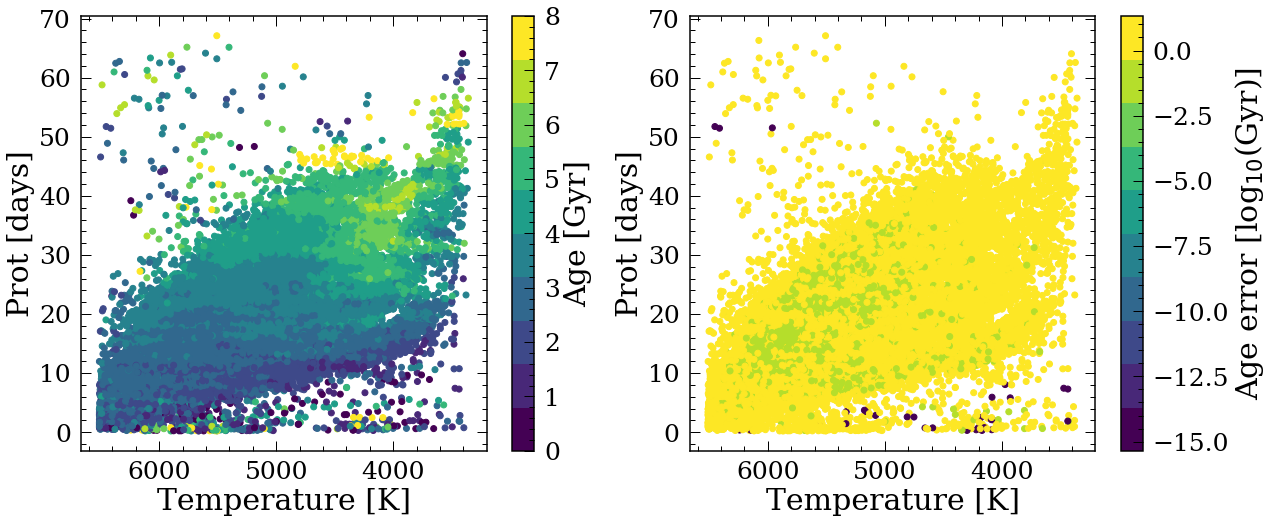

In [59]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_Prot_bin['teff_calc'],df_Prot_bin['Prot'],c=df_Prot_bin['age'],cmap=cm,vmin=0,vmax=8)
plt.gca().invert_xaxis()
cb=plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('Temperature [K]')
plt.ylabel('Prot [days]')

plt.subplot(1,2,2)

plt.scatter(df_Prot_bin['teff_calc'],df_Prot_bin['Prot'],c=np.log10(df_Prot_bin['age_err']),cmap=cm)
plt.gca().invert_xaxis()
cb=plt.colorbar()
cb.set_label('Age error [log$_{10}$(Gyr)]')
plt.xlabel('Temperature [K]')
plt.ylabel('Prot [days]')

plt.savefig('Kineages_Prot.png')

In [60]:
df_Prot_bin.to_pickle('NewData/ProtVP_MS_150_w015_bin.pkl')

# For Rvar

In [61]:
df_Rvar_bin=pd.read_pickle('RvarVP_MS_150_w015_bin.pkl')
Vd_bins=pd.read_table('VD_bin_rvar',delimiter=',')

df_Rvar_bin=pd.merge(df_Rvar_bin[[i for i in df_Rvar_bin.columns if i not in [' vd',' vd_err']]],
                     Vd_bins,left_on='KID',right_on='KID',how='inner')

df_Rvar_bin

,solution_id,designation,source_id,random_index,gaia_ref_epoch,ra,ra_error,dec,dec_error,parallax,...,rp_dered,bprp_dered,G_dered,teff_calc,v_t,v_b,abs_G,Rvar_log,vd,vd_err
0,1.635721e+18,Gaia DR2 2050231848829944320,2.050232e+18,2.980325e+08,2015.5,291.137620,0.019560,36.577344,0.025196,1.168913,...,14.264825,0.975974,14.829724,5313.795979,33.889670,-33.411547,5.517761,4.335097,10.516814,0.135130
1,1.635721e+18,Gaia DR2 2050233940470191872,2.050234e+18,1.444712e+09,2015.5,291.063824,0.269798,36.635671,0.391992,3.008085,...,12.854084,1.987765,13.857812,3783.045568,43.610090,-23.237122,6.280831,4.034140,14.535594,0.272751
2,1.635721e+18,Gaia DR2 2050232364226074624,2.050232e+18,1.045593e+09,2015.5,291.141664,0.030849,36.648235,0.033753,1.123321,...,15.069564,1.072990,15.685258,5058.354128,49.088081,-4.214296,6.159685,3.505987,18.637633,0.367074
3,1.635721e+18,Gaia DR2 2050235731480463616,2.050236e+18,2.819596e+08,2015.5,291.153283,0.060792,36.678799,0.069757,1.499367,...,14.256644,1.141436,14.915128,4898.417653,43.437266,36.144482,5.998116,3.252893,21.935564,0.356810
4,1.635721e+18,Gaia DR2 2050232776542967680,2.050233e+18,6.823268e+08,2015.5,291.163064,0.025876,36.674193,0.030111,1.239068,...,14.869585,1.072461,15.486587,5059.657160,91.357351,26.448217,6.161795,3.464520,19.362923,0.295691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88556,1.635721e+18,Gaia DR2 2139336408576560512,2.139336e+18,1.389496e+09,2015.5,289.921973,0.021650,52.406373,0.022294,0.787841,...,14.382293,0.963925,14.936403,5347.731327,25.186284,-10.180756,4.676241,3.255194,20.311940,0.184454
88557,1.635721e+18,Gaia DR2 2139336099338925312,2.139336e+18,2.699998e+08,2015.5,289.964228,0.023087,52.424308,0.025331,0.669294,...,14.502978,0.733841,14.948032,6043.922841,77.666784,4.480242,4.376738,3.309001,17.857717,0.169660
88558,1.635721e+18,Gaia DR2 2139341768695774336,2.139342e+18,1.626857e+09,2015.5,290.033980,0.031699,52.439817,0.030193,1.052836,...,14.949110,1.078574,15.558916,5044.668752,3.918576,-0.407244,5.892401,4.028109,12.005128,0.207024
88559,1.635721e+18,Gaia DR2 2139341906134738432,2.139342e+18,2.558871e+08,2015.5,290.058448,0.026208,52.453856,0.026837,0.807338,...,14.730165,0.978811,15.316444,5305.874615,90.360351,-43.141154,5.102241,3.525812,18.222421,0.612838


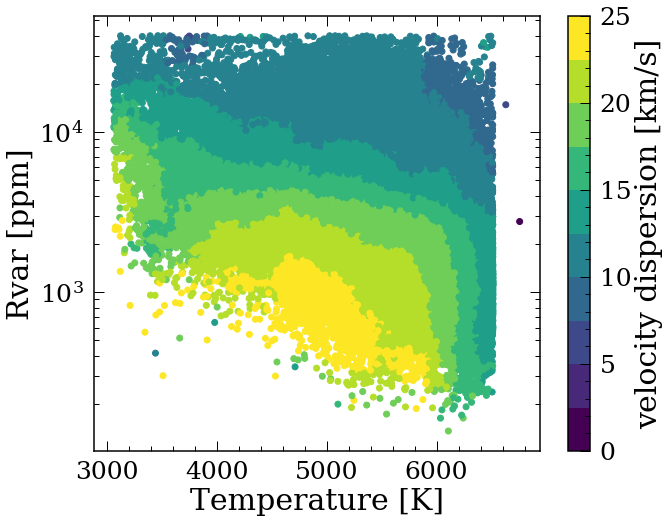

In [62]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_Rvar_bin['teff_calc'],df_Rvar_bin['Rvar'],c=df_Rvar_bin[' vd'],cmap=cm,vmin=0,vmax=25)
plt.gca().invert_xaxis()
plt.yscale('log')
cb=plt.colorbar()
cb.set_label('velocity dispersion [km/s]')
plt.xlabel('Temperature [K]')
plt.ylabel('Rvar [ppm]')
plt.gca().invert_xaxis()
plt.savefig('RvarVd.png')

In [63]:
p_mp, p_mr, p_a = get_avr_coefficients()
df_Rvar_bin['age']=v_to_age(df_Rvar_bin[' vd'],p_mp)

BSt=np.zeros((len(df_Rvar_bin),500))
for i in range(500):
    BSt[:,i]=genErr(df_Rvar_bin[' vd'], df_Rvar_bin[' vd_err'])

age_err=np.zeros(len(df_Rvar_bin))
for i in range(len(df_Rvar_bin)):
    age_err[i]=np.std(BSt[i,:])

df_Rvar_bin['age_err']=age_err

/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


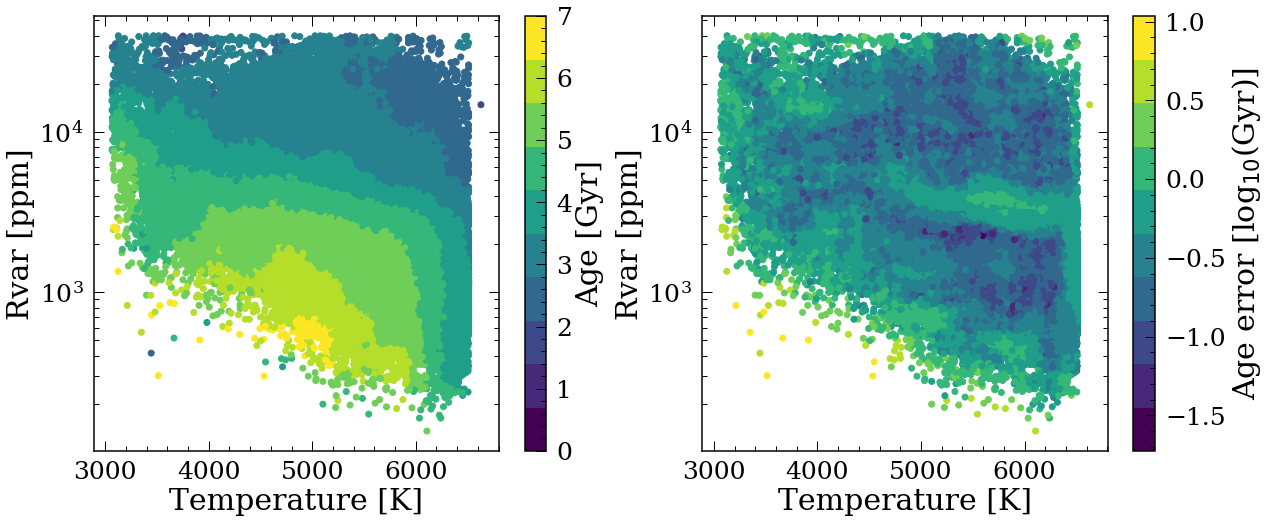

In [64]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_Rvar_bin['teff_calc'],df_Rvar_bin['Rvar'],c=df_Rvar_bin['age'],cmap=cm,vmin=0,vmax=7)
plt.gca().invert_xaxis()
cb=plt.colorbar()
cb.set_label('Age [Gyr]')
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('Rvar [ppm]')
plt.gca().invert_xaxis()

plt.subplot(1,2,2)
plt.scatter(df_Rvar_bin['teff_calc'],df_Rvar_bin['Rvar'],c=np.log10(df_Rvar_bin['age_err']),cmap=cm)
plt.gca().invert_xaxis()
cb=plt.colorbar()
cb.set_label('Age error [log$_{10}$(Gyr)]')
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('Rvar [ppm]')
plt.gca().invert_xaxis()

plt.savefig('Kineages_Rvar.png')

In [65]:
df_Rvar_bin.to_pickle('NewData/RvarVP_MS_150_w015_bin.pkl')

# Compare velocity disperison for Rvars and Prot

In [66]:
df_Rvar_bin=pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl')

In [67]:
df_Rvar_bin['dv_Rvar']=df_Rvar_bin[' vd']
df_Rvar_bin=df_Rvar_bin[['dv_Rvar','KID']]
df_Rvar_bin['age_Rvar']=v_to_age(df_Rvar_bin['dv_Rvar'],p_mp)
print(len(df_Rvar_bin))

88561


/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [68]:
df_Prot_Rvar=pd.merge(df_Prot_bin,df_Rvar_bin,left_on='KID',right_on='KID')
df_Prot_Rvar['dv_Prot']=df_Prot_Rvar[' vd']
print(len(df_Prot_Rvar))

20235


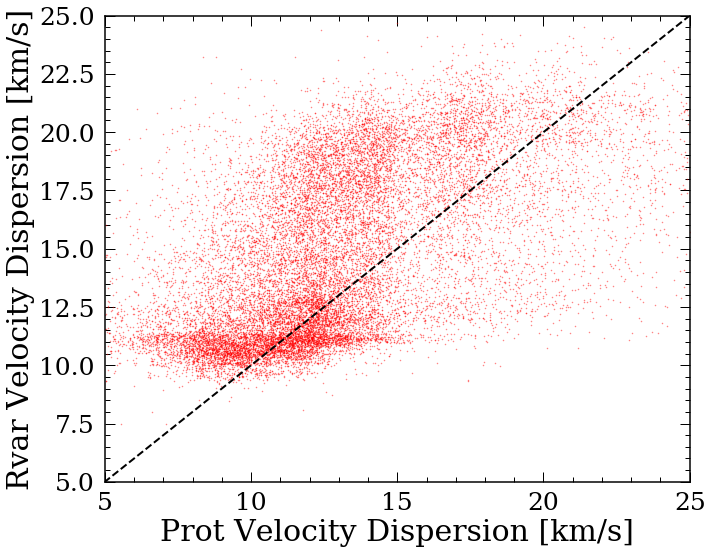

In [69]:
plt.figure(figsize=(10,8))
plt.plot(df_Prot_Rvar['dv_Prot'],df_Prot_Rvar['dv_Rvar'],'r.',markersize=1,alpha=0.5)
maxlim=max(max(df_Prot_Rvar['dv_Prot']),max(df_Prot_Rvar['dv_Rvar']))
minlim=min(min(df_Prot_Rvar['dv_Prot']),min(df_Prot_Rvar['dv_Rvar']))
plt.plot([minlim,maxlim],[minlim,maxlim],'k--')
plt.xlabel('Prot Velocity Dispersion [km/s]')
plt.ylabel('Rvar Velocity Dispersion [km/s]')
plt.ylim([5,25])
plt.xlim([5,25])
plt.tight_layout()
plt.savefig('Protvd_Rvarvd.png')

# use astraea to see if I can predict ages with Prot and Rvar

## Prot

In [46]:
df_Prot_bin=df_Prot_bin.dropna(subset=['Prot_log','teff_calc','age','age_err'])
regr, regr_outs = Astraea.RFregressor(df_Prot_bin, ['Prot_log','teff_calc'],
                                      target_var='age', target_var_err='age_err')


Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 2
Features attempt to train: ['Prot_log', 'teff_calc']
21355 stars in dataframe!
21355 total stars used for RF!
17084 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.007952741391798876
Average chi^2 is: 1053615190909.1057
Finished!


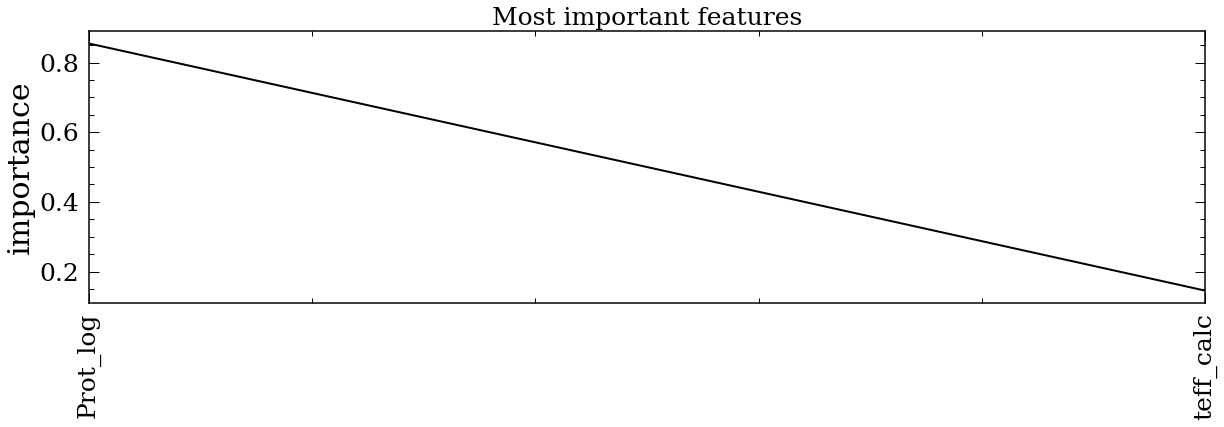

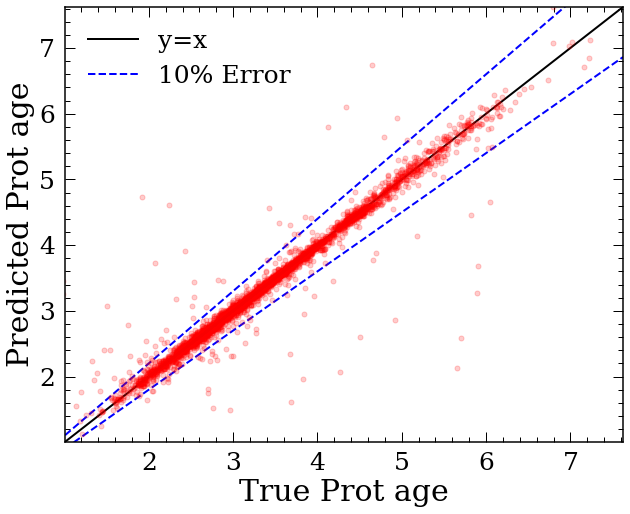

In [47]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='Prot age', MS=10)

## Rvar

In [48]:
df_Prot_Rvar=df_Prot_Rvar.dropna(subset=['Rvar','teff_calc','age_Rvar'])
regr, regr_outs = Astraea.RFregressor(df_Prot_Rvar, ['Rvar','teff_calc'],
                                      target_var='age_Rvar', target_var_err='age_err')



Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 2
Features attempt to train: ['Rvar', 'teff_calc']
20235 stars in dataframe!
20235 total stars used for RF!
16188 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.000736587141915592
Average chi^2 is: 0.00011425511174162004
Finished!


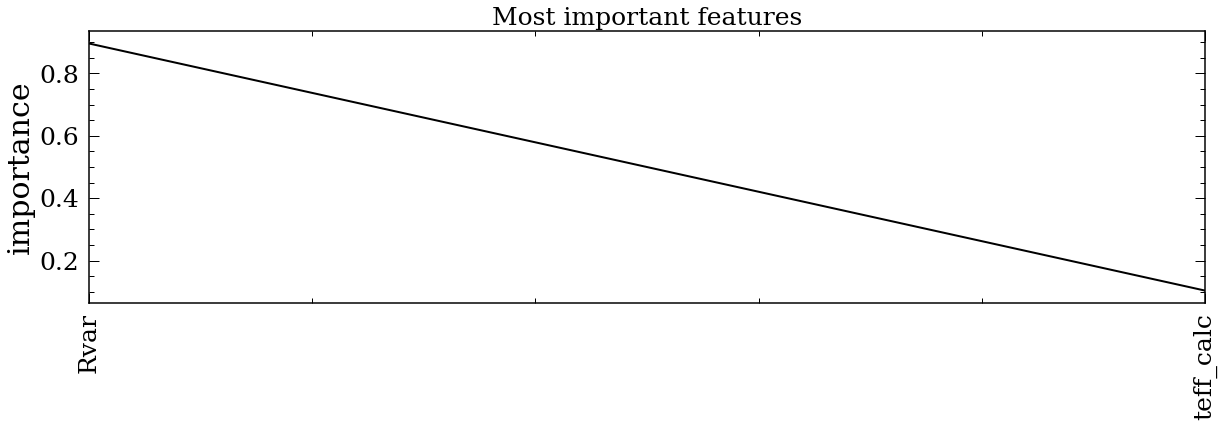

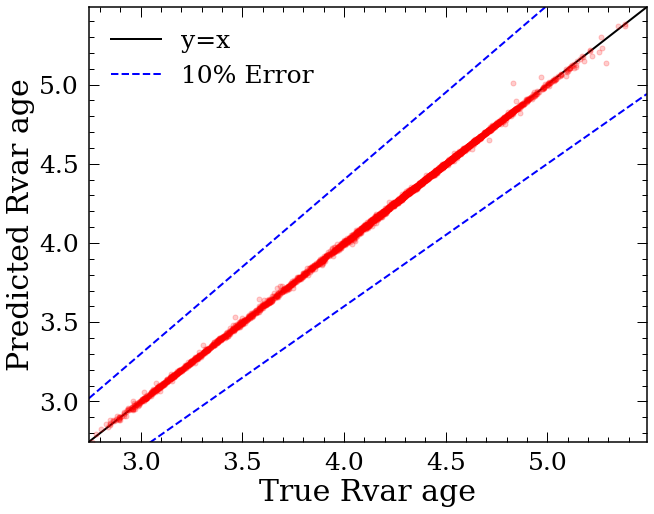

In [49]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='Rvar age', MS=10)

## Rvar to Prot age

In [50]:
df_Prot_Rvar=df_Prot_Rvar.dropna(subset=['Rvar','teff_calc','age'])
regr, regr_outs = Astraea.RFregressor(df_Prot_Rvar, ['Rvar','teff_calc'],
                                      target_var='age', target_var_err='age_err')


Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 2
Features attempt to train: ['Rvar', 'teff_calc']
20228 stars in dataframe!
20228 total stars used for RF!
16182 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.10041407344524281
Average chi^2 is: 0.8878687024698967
Finished!


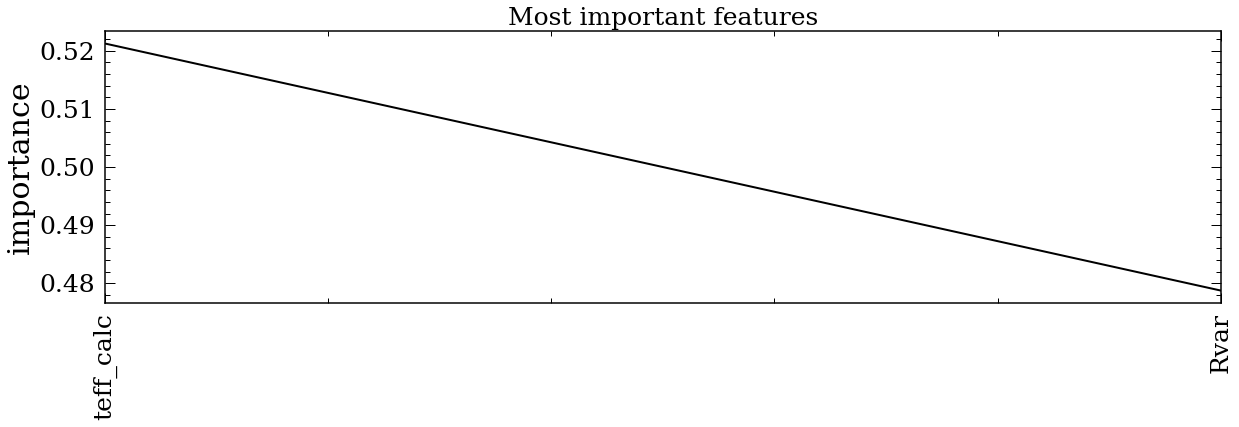

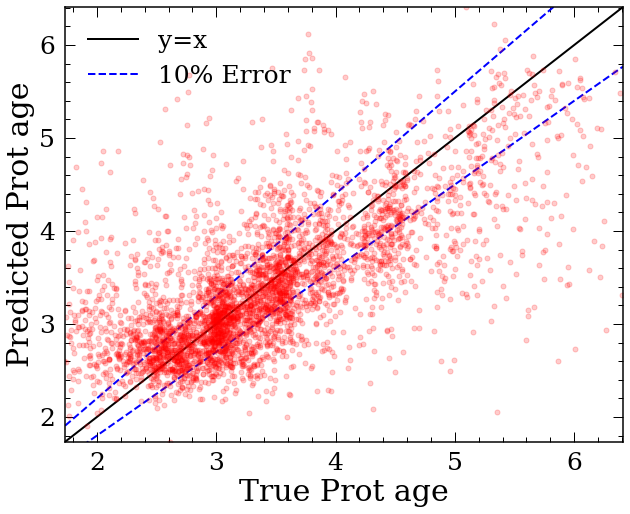

In [51]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='Prot age', MS=10)